In [0]:
import tensorflow as tf
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

class SuperUNet(nn.Module):
  def convolvePath(self, in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
        nn.Conv2d(out_channel, out_channel, kernel_size=3,  padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )

  def cropConcat(self, upsampled, contraction):
    _, _, a, b = upsampled.size()
    _, _, i, j = contraction.size()
    #u_size = min(a,b)
    y = contraction[:, :, (i-a)//2 : (i+a)//2,
                          (j-b)//2 : (j+b)//2]
    
    return torch.cat([upsampled, y], 1)


  def __init__(self, in_channel=3, out_channel=3, scale_factor=3):
    super(SuperUNet, self).__init__()
    # Contraction track
    self.contract1 = self.convolvePath(in_channel, 64)
    self.contract2 = self.convolvePath(64, 128)
    self.contract3 = self.convolvePath(128, 256)
    self.contract4 = self.convolvePath(256, 512)
    self.contract5 = self.convolvePath(512, 1024)

    self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=1, stride=1)
    self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=1, stride=1)
    self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=1, stride=1)
    self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=scale_factor,
                                        stride=scale_factor)

    # Expansion track
    self.expand4 = self.convolvePath(1024, 512)
    self.expand3 = self.convolvePath(512, 256)
    self.expand2 = self.convolvePath(256, 128)
    self.expand1 = nn.Sequential(
        nn.Conv2d(64, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, out_channel, 1)
    )

    pass

  def forward(self, image):
    ############# Contraction #############
    c1 = self.contract1(image)
    c2 = self.contract2(c1)
    c3 = self.contract3(c2)
    c4 = self.contract4(c3)
    c5 = self.contract5(c4)
    
    ############## Expansion ###############
    u4 = self.upsample4(c5)
    e4 = self.expand4(self.cropConcat(u4, c4))

    u3 = self.upsample3(e4)
    e3 = self.expand3(self.cropConcat(u3, c3))

    u2 = self.upsample2(e3)
    e2 = self.expand2(self.cropConcat(u2, c2))

    u1 = self.upsample1(e2)
    e1 = self.expand1(u1)

    return e1

In [0]:
!rm -rf train
!mkdir train
import requests
import random
import json
import shutil

from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 40%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def neko():
    sources = [7, 20]
    urls = []

    print("[Scrapping for neko images...]")
    for s in sources:
        afterdate = None
        for _ in xrange(150):
            q = 'https://redditbooru.com/api/images/?sources=%s' % s
            if afterdate is not None:
                q += '&afterDate=%s' % afterdate
            data = requests.get(q).json()
            if data is None: continue
            urls += list(filter(lambda d: not d['nsfw'], data))
            afterdate = min(d['dateCreated'] for d in data)

    print("[Finished getting all URLs]")
    print("[Got %d images]\n" % len(urls))
    count = 0

    print("Downloading images...")
    out = display(progress(0, len(urls)), display_id=True)

    for d in urls:
        resp = requests.get(d['cdnUrl'], stream=True)
        f = "train/%d.jpg" % count
        count += 1
        local_file = open(f, 'wb')

        resp.raw.decode_content = True

        shutil.copyfileobj(resp.raw, local_file)

        out.update(progress(count, len(urls)))

        del resp

    print("Finished downloading images")

if __name__ == '__main__':
    neko()

[Scrapping for neko images...]
[Finished getting all URLs]
[Got 6543 images]



KeyboardInterrupt: ignored

In [0]:
import cv2
import sys
import os.path
from google.colab.patches import cv2_imshow

n = 0

def detect(filename, i, cascade_file="lbpcascade_animeface.xml"):
    if not os.path.isfile(cascade_file):
        raise RuntimeError("%s: not found" % cascade_file)

    cascade = cv2.CascadeClassifier(cascade_file)
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    ## Suggested modification: increase minSize to '(250,250)' px,
    ## increasing proportion of high-quality faces & reducing
    ## false positives. Faces which are only 50x50px are useless
    ## and often not faces at all.

    faces = cascade.detectMultiScale(gray,
                                     # detector options
                                     scaleFactor = 1.1,
                                     minNeighbors = 5,
                                     minSize = (50, 50))
    global n

    for (x, y, w, h) in faces:
        cropped = image[y: y + h, x: x + w]
        if i > 300:
          cv2.imwrite(f"faces/train/{n}.jpg", cropped)
        else:
          cv2.imwrite(f"faces/test/{n}.jpg", cropped)
        n += 1

In [0]:
for i in range(975,6526):
  if not os.path.isfile(f"train/{i}.jpg"):
    continue
  
  detect(f"train/{i}.jpg", i)

error: ignored

In [0]:
import tensorflow as tf
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets, models
from PIL import Image
from google.colab.patches import cv2_imshow
import glob

In [0]:
class SimDataset(Dataset):
  def __init__(self, image_path):
    self.img = sorted(glob.glob(image_path + "/*"))
    

  def __getitem__(self, idx, in_size=128, out_size=512):
    tform = transforms.Compose([
        transforms.Resize(in_size)
    ])
    tform2 = transforms.Compose([
        transforms.Resize(out_size)
    ])

    img = Image.open(self.img[idx])
    img = np.asarray(tform(img))
    img = np.moveaxis(img, -1, 0)

    msk = Image.open(self.img[idx])
    msk = np.asarray(tform2(msk))
    msk = np.moveaxis(msk, -1, 0)

    return (torch.from_numpy(img).float(), torch.from_numpy(msk).float())
  
  def __len__(self):
    return len(self.img)

In [0]:
unet = SuperUNet(3, 3, 4).cuda()

In [0]:
def test_model(test_set, criterion):
  unet.eval()
  test_loss, test_acc = 0.0, 0.0
  for batch, (image, mask) in enumerate(test_set):
    image, mask = Variable(image.cuda()), Variable(mask.cuda())
    output = unet(image)

    loss = criterion(output, mask)
    test_loss += loss.item()
  
  return test_loss / batch


def train(epochs=50, batch_size=1, test_rate=1, criterion=nn.MSELoss(),
          optimizer = torch.optim.Adam(unet.parameters(), lr=0.001),
          logging=True):
  for epoch in range(epochs):
    epoch_loss, epoch_acc = 0.0, 0.0
    unet.train()

    for batch, (images, masks) in enumerate(train_data):
      images = Variable(images.cuda())
      masks = Variable(masks.cuda())

      # Forward bass
      outputs = unet(images)

      # Back prop
      loss = criterion(outputs, masks)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Record data
      epoch_loss += loss.item()


    # Average epoch loss and accuracy
    epoch_loss /= batch

    # Append to list
    train_loss.append(  (len(train_loss), epoch_loss)  )

    if epoch % test_rate == 0:
      t_loss = test_model(test_data, criterion)
      test_loss.append( (len(train_loss) - 1, t_loss) )

      if logging:
        print("Epoch: %d\n\t Train Loss: %f\n\t Test Loss: %f\n" % \
              (len(train_loss), epoch_loss, t_loss))
    else:
      if logging:
        print("Epoch: %d\n\t Train Loss: %f\n" % \
              (len(train_loss), epoch_loss))

In [0]:
train_data = SimDataset("faces/train")
test_data = SimDataset("faces/test")
train_data = torch.utils.data.DataLoader(train_data, shuffle=True)
test_data = torch.utils.data.DataLoader(test_data)

In [0]:
train_loss, test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train()

Epoch: 1
	 Train Loss: 33052.277037
	 Test Loss: 31581.340054



In [44]:
image = cv2.imread("small.png")
image = np.moveaxis(image, -1, 0)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = torch.from_numpy(image).float().cuda()
a = unet.eval()
out = a(image)
print(out.shape)

torch.Size([1, 3, 1796, 1796])


In [47]:
out = out.detach().cpu().numpy()
print(out)

[[[[239.78644 240.80312 242.02933 ... 241.56773 241.39339 239.33179]
   [242.37938 242.56108 242.1856  ... 243.69818 242.4983  240.17407]
   [243.9492  243.7174  242.03758 ... 245.91103 243.95119 240.39041]
   ...
   [246.70747 246.8589  248.46925 ... 244.20428 244.03127 242.57408]
   [245.7798  246.75677 247.84517 ... 242.95497 242.01277 239.46329]
   [245.77127 247.36166 248.23122 ... 242.76556 240.35712 236.26093]]

  [[233.29474 235.20227 235.6807  ... 226.37144 225.20238 222.3305 ]
   [237.09683 237.47948 236.88145 ... 229.17062 227.30754 223.59792]
   [239.3811  239.10034 238.6888  ... 231.98253 229.93202 224.15288]
   ...
   [235.22351 236.64319 239.93982 ... 236.93037 235.41515 231.35165]
   [233.09003 235.46765 238.9094  ... 234.61032 232.26973 226.99283]
   [231.90034 234.45811 237.17249 ... 232.97513 229.01196 222.81953]]

  [[227.65143 229.16212 229.70775 ... 224.23059 222.8262  220.07901]
   [230.80696 231.24913 231.00598 ... 227.19067 225.2376  221.38293]
   [232.9935  23

In [0]:
out = out.reshape((3, 1796, 1796))

In [0]:
out = np.moveaxis(out, 0, -1)

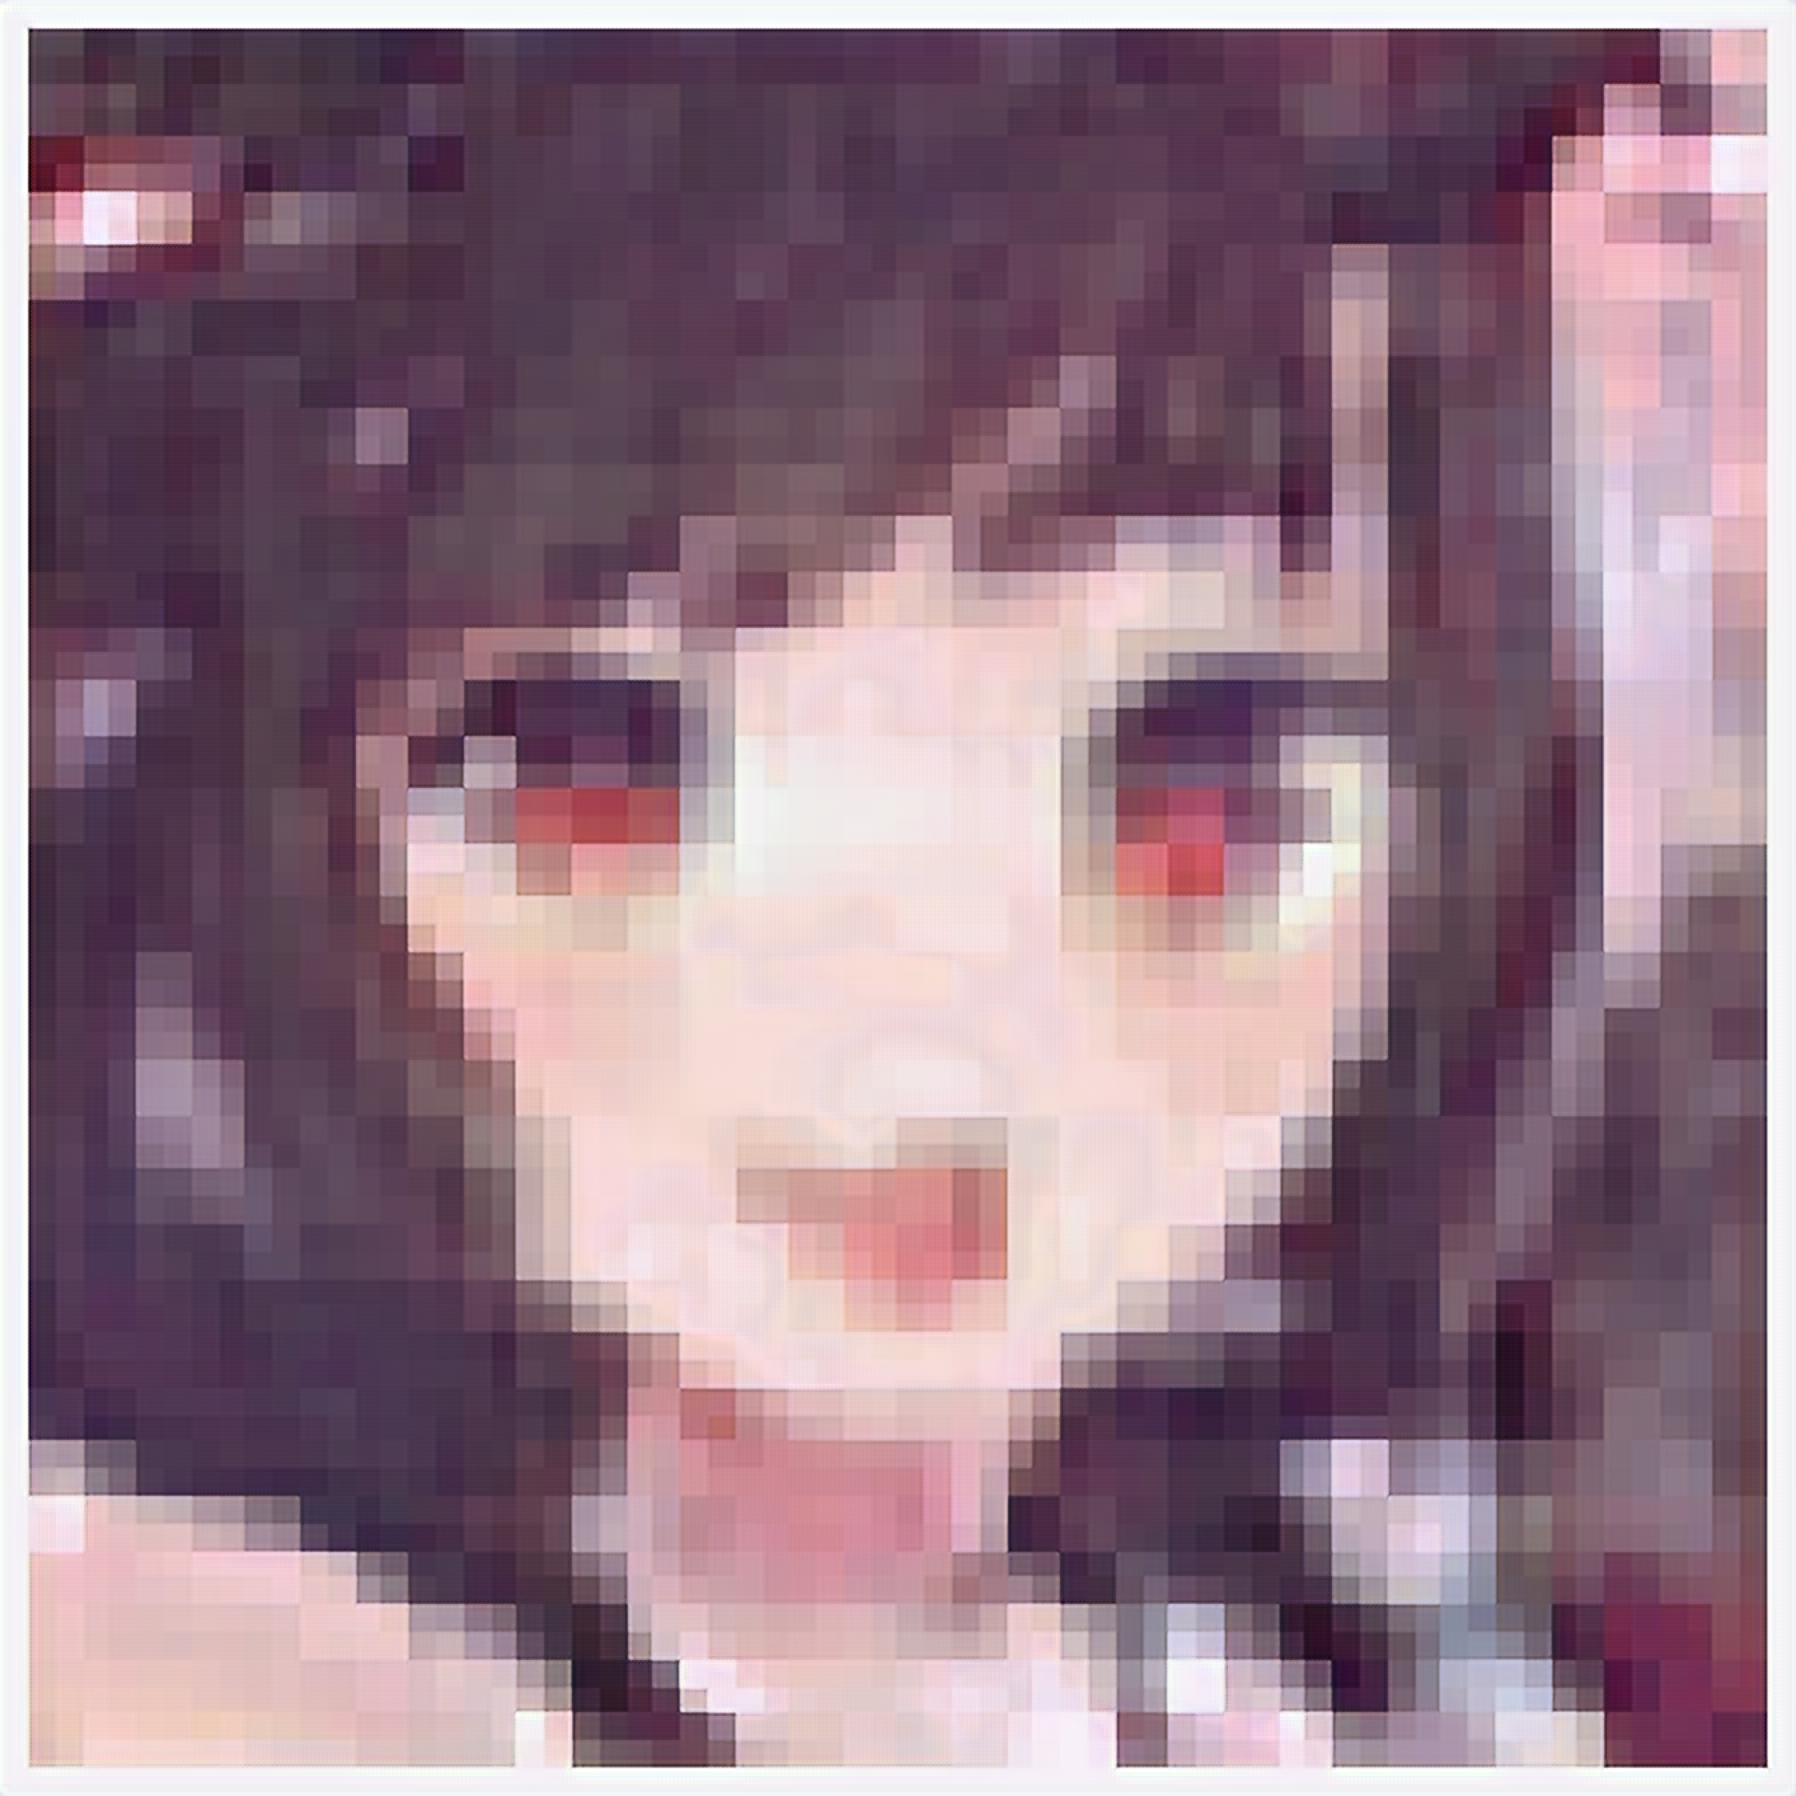

In [50]:
cv2_imshow(out)